In [ ]:
!pip install -q torch torchvision timm tqdm pillow kaggle


In [ ]:
# Upload your kaggle.json (from your Kaggle account)
from google.colab import files
files.upload()  # choose kaggle.json when prompted


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"swethavasireddi","key":"7b7331c13fe448b2c461c6bf72f029cd"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d perke986/face-mask-segmentation-dataset
!unzip -q face-mask-segmentation-dataset.zip -d face-mask-segmentation-dataset
!ls face-mask-segmentation-dataset/images | head
!ls face-mask-segmentation-dataset/masks | head


Dataset URL: https://www.kaggle.com/datasets/perke986/face-mask-segmentation-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/78.9M [00:00<?, ?B/s]
100% 78.9M/78.9M [00:00<00:00, 1.76GB/s]
coronavirus-4947340_1920.jpg
coronavirus-5064371_1920.jpg
mask-4898571_1920.jpg
mask-5136259_1920.jpg
mouth-guard-5060809_1920.jpg
mouth-guard-5068146_1920.jpg
nurse-4962034_1920.jpg
pexels-andrea-piacquadio-3881247.jpg
pexels-anna-shvets-3902881.jpg
pexels-anna-shvets-3943881.jpg
coronavirus-4947340_1920.png
coronavirus-5064371_1920.png
mask-4898571_1920.png
mask-5136259_1920.png
mouth-guard-5060809_1920.png
mouth-guard-5068146_1920.png
nurse-4962034_1920.png
pexels-andrea-piacquadio-3881247.png
pexels-anna-shvets-3902881.png
pexels-anna-shvets-3943881.png


In [ ]:
import os, torch, timm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# ---------------- Dataset ----------------
class FaceMaskSegDataset(Dataset):
    def __init__(self, root_dir, img_size=256):
        self.root_dir = root_dir
        self.images_dir = os.path.join(root_dir, "images")
        self.masks_dir = os.path.join(root_dir, "masks")
        self.img_names = sorted(os.listdir(self.images_dir))
        self.tf_img = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
        ])
        self.tf_mask = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
        ])

    def __len__(self): return len(self.img_names)

    def __getitem__(self, idx):
        name = self.img_names[idx]
        img_path  = os.path.join(self.images_dir, name)
        mask_path = os.path.join(self.masks_dir, os.path.splitext(name)[0] + ".png")
        img  = self.tf_img(Image.open(img_path).convert("RGB"))
        mask = self.tf_mask(Image.open(mask_path).convert("L"))
        mask = (mask > 0.5).long().squeeze(0)
        return img, mask


In [ ]:
# ---------------- ViT Backbone ----------------
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm

class ViTExtractor(nn.Module):
    """
    Extracts intermediate features from a pretrained Vision Transformer (DINO or ViT backbone).
    We register forward hooks on the selected transformer blocks.
    """
    def __init__(self, model_name="vit_base_patch16_224", selected_layers=[2,5,8,11]):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=True)
        self.selected_layers = selected_layers
        self.patch_size = self.model.patch_embed.patch_size[0]
        self.embed_dim = self.model.embed_dim
        self._features = {}

        # Register hooks to capture intermediate outputs
        for i, blk in enumerate(self.model.blocks):
            if i in selected_layers:
                blk.register_forward_hook(self._hook(i))

    def _hook(self, idx):
        def fn(_, __, output):
            self._features[idx] = output
        return fn

    def forward(self, x):
        self._features = {}
        _ = self.model.forward_features(x)
        feats = [self._features[i] for i in sorted(self._features.keys())]
        out = []
        for f in feats:
            # Remove CLS token if present
            if f.shape[1] > (x.shape[2] // self.patch_size) ** 2:
                f = f[:, 1:, :]
            out.append(f)
        return out


# ---------------- SegDINO Decoder ----------------
class SegDINO(nn.Module):
    """
    Lightweight segmentation decoder for DINO/ViT features.
    """
    def __init__(self, backbone, n_classes=2, c_out=64):
        super().__init__()
        self.backbone = backbone
        self.c_out = c_out
        self.n_classes = n_classes
        self.align = None
        self.head = None

    def _init_layers(self, n_levels, embed_dim):
        # simple linear alignment and lightweight segmentation head
        self.align = nn.ModuleList([
            nn.Sequential(nn.Linear(embed_dim, self.c_out), nn.GELU())
            for _ in range(n_levels)
        ])
        self.head = nn.Sequential(
            nn.Conv2d(n_levels * self.c_out, n_levels * self.c_out, 1),
            nn.GELU(),
            nn.Conv2d(n_levels * self.c_out, self.n_classes, 1)
        )

    def forward(self, x):
        feats = self.backbone(x)
        if self.align is None:
            self._init_layers(len(feats), self.backbone.embed_dim)
            # ✅ Ensure decoder layers move to same device as input
            self.align = self.align.to(x.device)
            self.head = self.head.to(x.device)

        maps = []
        for i, f in enumerate(feats):
            B, N, C = f.shape
            H = W = int(N ** 0.5)
            f = self.align[i](f)
            f = f.permute(0, 2, 1).reshape(B, self.c_out, H, W)
            maps.append(f)

        # Upsample and concatenate multi-scale features
        maxH = max(m.shape[-2] for m in maps)
        maxW = max(m.shape[-1] for m in maps)
        ups = [F.interpolate(m, (maxH, maxW), mode="bilinear", align_corners=False) for m in maps]
        fused = torch.cat(ups, 1)
        out = self.head(fused)
        return F.interpolate(out, size=(x.shape[-2], x.shape[-1]), mode="bilinear", align_corners=False)


In [ ]:
def dice_score(pred, mask):
    pred=(pred>0.5).float(); mask=mask.float()
    inter=(pred*mask).sum(); union=pred.sum()+mask.sum()
    return (2*inter+1e-6)/(union+1e-6)

def train_one_epoch(model, loader, opt, dev):
    model.train(); ce=nn.CrossEntropyLoss(); total=0
    for imgs,masks in tqdm(loader,desc="Training"):
        imgs,masks=imgs.to(dev),masks.to(dev)
        opt.zero_grad()
        out=model(imgs)
        loss=ce(out,masks)
        loss.backward(); opt.step()
        total+=loss.item()*imgs.size(0)
    return total/len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, dev):
    model.eval(); dices=[]
    for imgs,masks in tqdm(loader,desc="Evaluating"):
        imgs,masks=imgs.to(dev),masks.to(dev)
        out=model(imgs)
        probs=torch.softmax(out,1)[:,1]
        dices.append(dice_score(probs,masks).item())
    return np.mean(dices)


In [ ]:
data_root = "face-mask-segmentation-dataset"
img_size = 224    # ✅ changed
batch_size = 4
epochs = 25
lr = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = FaceMaskSegDataset(data_root, img_size)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(dataset, batch_size=1, shuffle=False)

backbone = ViTExtractor("vit_base_patch16_224", [2,5,8,11])
model = SegDINO(backbone, n_classes=2).to(device)

for p in backbone.parameters():
    p.requires_grad = False

# 🔧 Dummy input to initialize decoder
dummy = torch.randn(1, 3, img_size, img_size).to(device)
_ = model(dummy)

opt = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=lr)

for e in range(epochs):
    loss = train_one_epoch(model, loader, opt, device)
    dice = evaluate(model, val_loader, device)
    print(f"Epoch {e+1}/{epochs} | Loss={loss:.4f} | Dice={dice:.4f}")

torch.save(model.state_dict(), "segdino_facemask.pth")
print("✅ Training complete! Model saved as segdino_facemask.pth")


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.29it/s]


Epoch 1/25 | Loss=0.2863 | Dice=0.0000


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.30it/s]


Epoch 2/25 | Loss=0.0592 | Dice=0.3287


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.33it/s]


Epoch 3/25 | Loss=0.0339 | Dice=0.4959


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.33it/s]


Epoch 4/25 | Loss=0.0283 | Dice=0.5271


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.43it/s]


Epoch 5/25 | Loss=0.0261 | Dice=0.5494


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.38it/s]


Epoch 6/25 | Loss=0.0246 | Dice=0.5962


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.32it/s]


Epoch 7/25 | Loss=0.0232 | Dice=0.6038


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.29it/s]


Epoch 8/25 | Loss=0.0220 | Dice=0.6273


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.28it/s]


Epoch 9/25 | Loss=0.0211 | Dice=0.6242


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.25it/s]


Epoch 10/25 | Loss=0.0203 | Dice=0.6569


Evaluating: 100%|██████████| 222/222 [00:22<00:00,  9.65it/s]


Epoch 11/25 | Loss=0.0192 | Dice=0.6545


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.47it/s]


Epoch 12/25 | Loss=0.0184 | Dice=0.6684


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.44it/s]


Epoch 13/25 | Loss=0.0177 | Dice=0.6593


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.45it/s]


Epoch 14/25 | Loss=0.0172 | Dice=0.6868


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.43it/s]


Epoch 15/25 | Loss=0.0165 | Dice=0.6927


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.43it/s]


Epoch 16/25 | Loss=0.0159 | Dice=0.6788


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.40it/s]


Epoch 17/25 | Loss=0.0155 | Dice=0.7002


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.47it/s]


Epoch 18/25 | Loss=0.0150 | Dice=0.7150


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.64it/s]


Epoch 19/25 | Loss=0.0147 | Dice=0.7165


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.60it/s]


Epoch 20/25 | Loss=0.0143 | Dice=0.7267


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.39it/s]


Epoch 21/25 | Loss=0.0140 | Dice=0.7260


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.36it/s]


Epoch 22/25 | Loss=0.0137 | Dice=0.7355


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.36it/s]


Epoch 23/25 | Loss=0.0135 | Dice=0.7399


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.38it/s]


Epoch 24/25 | Loss=0.0132 | Dice=0.7350


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.36it/s]


Epoch 25/25 | Loss=0.0129 | Dice=0.7399
✅ Training complete! Model saved as segdino_facemask.pth


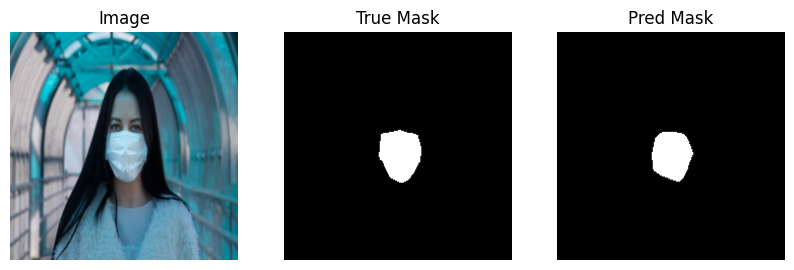

In [ ]:
model.eval()
img,mask=dataset[0]
with torch.no_grad():
    out=model(img.unsqueeze(0).to(device))
    pred=torch.softmax(out,1)[0,1].cpu()

plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(img.permute(1,2,0)); plt.title("Image"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(mask,cmap="gray"); plt.title("True Mask"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(pred>0.5,cmap="gray"); plt.title("Pred Mask"); plt.axis("off")
plt.show()


In [ ]:
mean_dice = evaluate(model, val_loader, device)
print(f"Mean Dice Score on validation set: {mean_dice:.4f}")


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.34it/s]

Mean Dice Score on validation set: 0.7399


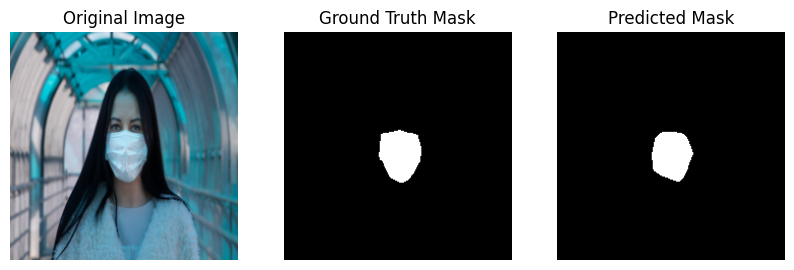

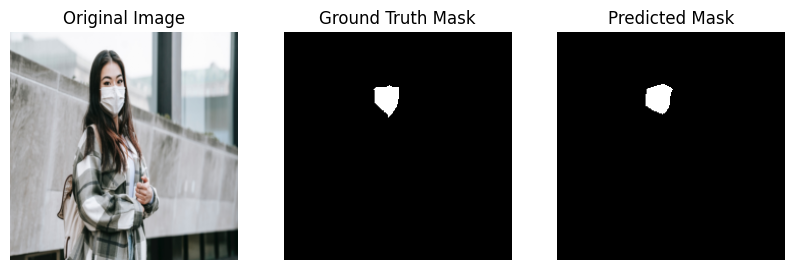

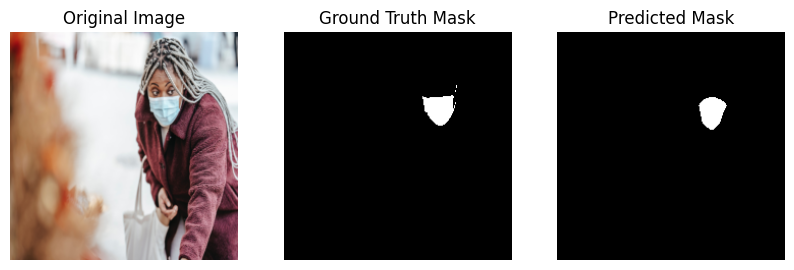

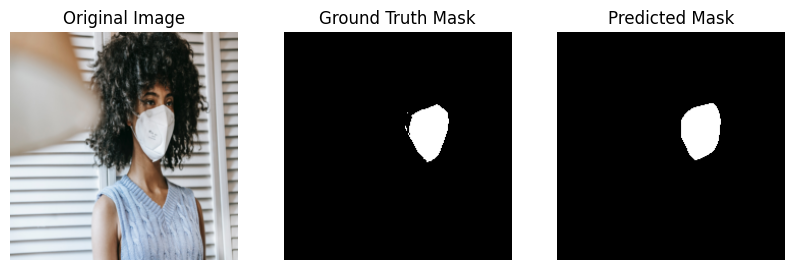

In [ ]:
import matplotlib.pyplot as plt
model.eval()

# Pick some random samples
for idx in [0, 50, 120, 200]:
    img, mask = dataset[idx]
    with torch.no_grad():
        pred = torch.softmax(model(img.unsqueeze(0).to(device)), 1)[0, 1].cpu()

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred > 0.5, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()


In [ ]:
train_losses, val_dices = [], []

best_dice = 0
for e in range(epochs):
    loss = train_one_epoch(model, loader, opt, device)
    dice = evaluate(model, val_loader, device)
    train_losses.append(loss)
    val_dices.append(dice)
    print(f"Epoch {e+1}/{epochs} | Loss={loss:.4f} | Dice={dice:.4f}")
    if dice > best_dice:
        best_dice = dice
        torch.save(model.state_dict(), "best_segdino_facemask.pth")
        print(f"✅ Best model saved (Dice={dice:.4f})")


Evaluating: 100%|██████████| 222/222 [00:24<00:00,  9.08it/s]


Epoch 1/25 | Loss=0.0127 | Dice=0.7391
✅ Best model saved (Dice=0.7391)


Evaluating: 100%|██████████| 222/222 [00:25<00:00,  8.60it/s]


Epoch 2/25 | Loss=0.0125 | Dice=0.7449
✅ Best model saved (Dice=0.7449)


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.36it/s]


Epoch 3/25 | Loss=0.0123 | Dice=0.7412


Evaluating: 100%|██████████| 222/222 [00:24<00:00,  8.99it/s]


Epoch 4/25 | Loss=0.0121 | Dice=0.7544
✅ Best model saved (Dice=0.7544)


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.30it/s]


Epoch 5/25 | Loss=0.0119 | Dice=0.7589
✅ Best model saved (Dice=0.7589)


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.32it/s]


Epoch 6/25 | Loss=0.0118 | Dice=0.7537


Evaluating: 100%|██████████| 222/222 [00:24<00:00,  9.15it/s]


Epoch 7/25 | Loss=0.0116 | Dice=0.7590
✅ Best model saved (Dice=0.7590)


Evaluating: 100%|██████████| 222/222 [00:24<00:00,  9.17it/s]


Epoch 8/25 | Loss=0.0114 | Dice=0.7592
✅ Best model saved (Dice=0.7592)


Evaluating: 100%|██████████| 222/222 [00:24<00:00,  8.90it/s]


Epoch 9/25 | Loss=0.0113 | Dice=0.7635
✅ Best model saved (Dice=0.7635)


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.28it/s]


Epoch 10/25 | Loss=0.0112 | Dice=0.7778
✅ Best model saved (Dice=0.7778)


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.27it/s]


Epoch 11/25 | Loss=0.0110 | Dice=0.7725


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.27it/s]


Epoch 12/25 | Loss=0.0109 | Dice=0.7670


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.27it/s]


Epoch 13/25 | Loss=0.0108 | Dice=0.7744


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.52it/s]


Epoch 14/25 | Loss=0.0106 | Dice=0.7744


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.42it/s]


Epoch 15/25 | Loss=0.0105 | Dice=0.7818
✅ Best model saved (Dice=0.7818)


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.43it/s]


Epoch 16/25 | Loss=0.0103 | Dice=0.7810


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.45it/s]


Epoch 17/25 | Loss=0.0102 | Dice=0.7797


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.46it/s]


Epoch 18/25 | Loss=0.0101 | Dice=0.7805


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.45it/s]


Epoch 19/25 | Loss=0.0100 | Dice=0.7876
✅ Best model saved (Dice=0.7876)


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.39it/s]


Epoch 20/25 | Loss=0.0099 | Dice=0.7943
✅ Best model saved (Dice=0.7943)


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.42it/s]


Epoch 21/25 | Loss=0.0098 | Dice=0.8024
✅ Best model saved (Dice=0.8024)


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.41it/s]


Epoch 22/25 | Loss=0.0097 | Dice=0.7938


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.38it/s]


Epoch 23/25 | Loss=0.0096 | Dice=0.8024


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.39it/s]


Epoch 24/25 | Loss=0.0095 | Dice=0.7988


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.30it/s]


Epoch 25/25 | Loss=0.0094 | Dice=0.8034
✅ Best model saved (Dice=0.8034)


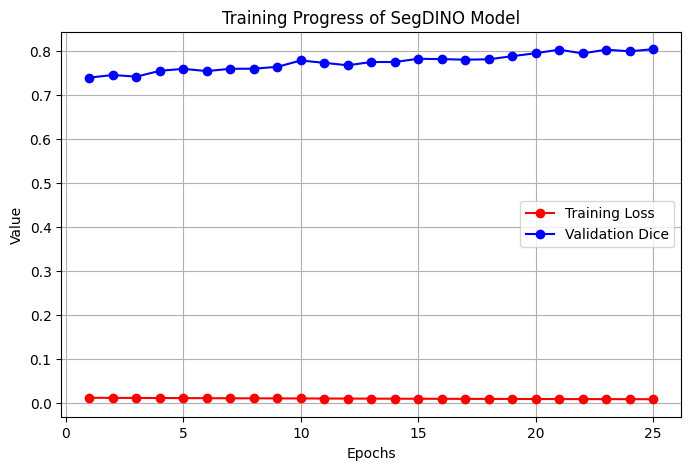

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses)+1), train_losses, 'r-o', label='Training Loss')
plt.plot(range(1, len(val_dices)+1), val_dices, 'b-o', label='Validation Dice')
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Training Progress of SegDINO Model")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix

@torch.no_grad()
def compute_metrics(model, loader, device):
    model.eval()
    ious, precs, recs, f1s = [], [], [], []
    for imgs, masks in loader:
        imgs, masks = imgs.to(device), masks.to(device)
        out = model(imgs)
        probs = torch.softmax(out, 1)[:, 1]
        preds = (probs > 0.5).float().cpu().numpy().flatten()
        gt = masks.cpu().numpy().flatten()
        tn, fp, fn, tp = confusion_matrix(gt, preds, labels=[0,1]).ravel()
        iou = tp / (tp + fp + fn + 1e-6)
        prec = tp / (tp + fp + 1e-6)
        rec = tp / (tp + fn + 1e-6)
        f1 = 2 * prec * rec / (prec + rec + 1e-6)
        ious.append(iou); precs.append(prec); recs.append(rec); f1s.append(f1)
    return {
        "IoU": np.mean(ious),
        "Precision": np.mean(precs),
        "Recall": np.mean(recs),
        "F1": np.mean(f1s)
    }

metrics = compute_metrics(model, val_loader, device)
print("📊 SegDINO Model Evaluation Metrics:")
for k,v in metrics.items():
    print(f"{k}: {v:.4f}")


📊 SegDINO Model Evaluation Metrics:
IoU: 0.7123
Precision: 0.8294
Recall: 0.7866
F1: 0.8034


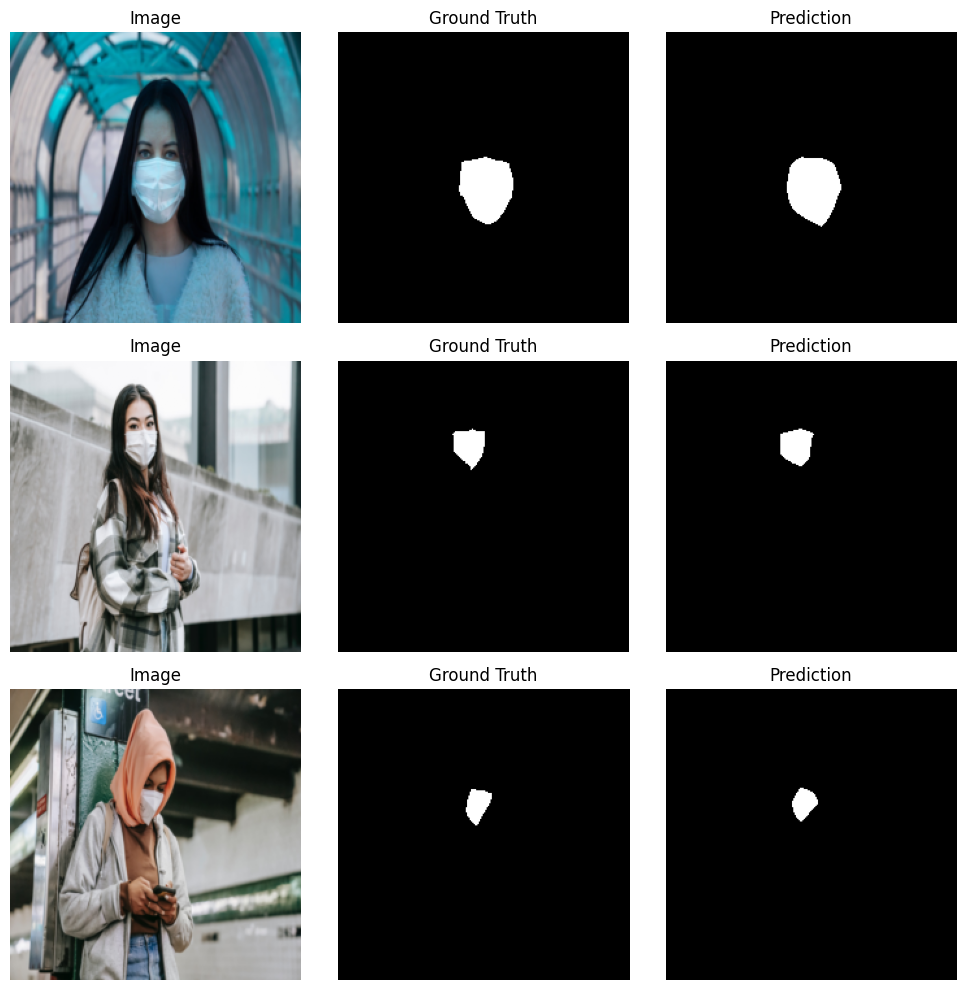

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(10,10))
indices = [0, 50, 100]
for i, idx in enumerate(indices):
    img, mask = dataset[idx]
    with torch.no_grad():
        pred = torch.softmax(model(img.unsqueeze(0).to(device)),1)[0,1].cpu()
    axes[i,0].imshow(img.permute(1,2,0)); axes[i,0].set_title("Image"); axes[i,0].axis("off")
    axes[i,1].imshow(mask, cmap="gray"); axes[i,1].set_title("Ground Truth"); axes[i,1].axis("off")
    axes[i,2].imshow(pred>0.5, cmap="gray"); axes[i,2].set_title("Prediction"); axes[i,2].axis("off")
plt.tight_layout()
plt.show()
